# PyXspec Tutorial

This is a tutorial on how to use the PyXspec package to analyze X-ray data. PyXspec is a Python interface to the XSPEC spectral fitting package. XSPEC is a spectral fitting package developed by NASA's High Energy Astrophysics Science Archive Research Center (HEASARC). 

### Importing the necessary packages & set-up

In [1]:
import os, sys, shutil
import xspec as xs
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
xs.Xset.chatter = 1
xs.Fit.statMethod = "cstat"  # fitting statistics = Cash-statistics
xs.Xset.cosmo = "70 0 0.7"  # H0=70, q0=0, O_lambda=0.7
xs.Xset.abund = "aspl"  # Reference abundance table Asplund+09

In [3]:
# obtain parameter values

exposure_src = fits.getval("Data/em01_crab_Spe_820_SourceSpec_00001.fits", 
                           "exposure", ext=1)
exposure_bkg = fits.getval("Data/em01_bg_crab_Spe_820_SourceSpec_00001.fits", 
                           "exposure", ext=1)
backscal_src = fits.getval("Data/em01_crab_Spe_820_SourceSpec_00001.fits", 
                           "backscal", ext=1)
backscal_bkg = fits.getval("Data/em01_bg_crab_Spe_820_SourceSpec_00001.fits", 
                           "backscal", ext=1)
regarea_src = fits.getval("Data/em01_crab_Spe_820_SourceSpec_00001.fits", 
                          "regarea", ext=1)
regarea_bkg = fits.getval("Data/em01_bg_crab_Spe_820_SourceSpec_00001.fits", 
                          "regarea", ext=1)
# arfmax_src = fits.getdata("Data/em01_crab_Spe_820_SourceSpec_00001.fits", 
#                           ext=1)["SPECRESP"].max()
# arfmax_bkg = fits.getdata("Data/em01_bg_crab_Spe_820_SourceSpec_00001.fits", 
#                           ext=1)["SPECRESP"].max()

r_src = regarea_src / backscal_src
r_bkg = regarea_bkg / backscal_bkg


# copy files and modify values
shutil.copy("Data/em01_crab_Spe_820_SourceSpec_00001.fits",
            "Data/em01_crab_Spe_820_SourceSpec_00001_corr.fits")
fits.setval("Data/em01_crab_Spe_820_SourceSpec_00001_corr.fits",
            "exposure", value=exposure_src / r_src, ext=1)
shutil.copy("Data/em01_bg_crab_Spe_820_SourceSpec_00001.fits",
            "Data/em01_bg_crab_Spe_820_SourceSpec_00001_corr.fits")
fits.setval("Data/em01_bg_crab_Spe_820_SourceSpec_00001_corr.fits",
            "exposure", value=exposure_bkg / r_bkg * (regarea_bkg / regarea_src) , ext=1)

shutil.copy("Data/em01_crab_Spe_820_ARF_00001.fits",
            "Data/em01_crab_Spe_820_ARF_00001_corr.fits",)
with fits.open("Data/em01_crab_Spe_820_ARF_00001_corr.fits") as hdu:
    hdu[1].data["SPECRESP"] *= r_src
    hdu.writeto("Data/em01_crab_Spe_820_ARF_00001_corr.fits", overwrite=True)
shutil.copy("Data/em01_bg_crab_Spe_820_ARF_00001.fits",
            "Data/em01_bg_crab_Spe_820_ARF_00001_corr.fits",)
with fits.open("Data/em01_bg_crab_Spe_820_ARF_00001_corr.fits") as hdu:
    hdu[1].data["SPECRESP"] *= r_bkg
    hdu.writeto("Data/em01_bg_crab_Spe_820_ARF_00001_corr.fits", overwrite=True)

### Importing the data

In [4]:
xs.AllData.clear()

test_dir = os.getcwd()
os.chdir('Data/')

sp_src = xs.Spectrum('em01_crab_Spe_820_SourceSpec_00001_corr.fits')
sp_src.multiresponse[0].arf = "em01_crab_Spe_820_ARF_00001_corr.fits"
sp_src.multiresponse[1] = "em01_crab_Spe_820_RMF_00001.fits"
sp_src.multiresponse[1].arf = "em01_crab_Spe_820_ARF_00001_corr.fits"
sp_src.multiresponse[2] = "em01_crab_Spe_820_RMF_00001.fits"

sp_bkg = xs.Spectrum('em01_bg_crab_Spe_820_SourceSpec_00001_corr.fits')
sp_bkg.multiresponse[0] = None
sp_bkg.multiresponse[1] = "em01_bg_crab_Spe_820_RMF_00001.fits"
sp_bkg.multiresponse[1].arf = "em01_bg_crab_Spe_820_ARF_00001_corr.fits"
sp_bkg.multiresponse[2] = "em01_bg_crab_Spe_820_RMF_00001.fits"

os.chdir(test_dir)

xs.AllData.ignore("**-0.3,7.0-**")

In [5]:
xs.Xset.chatter = 10
xs.AllData.show()
xs.Xset.chatter = 1


2 files 2 spectra 
Spectrum 1  Spectral Data File: em01_crab_Spe_820_SourceSpec_00001_corr.fits
Net count rate (cts/s) for Spectrum:1  9.463e+02 +/- 3.519e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  40-722
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 76.4 sec
 Using fit statistic: cstat
 Using Response (RMF) File            em01_crab_Spe_820_RMF_00001.fits for Source 1
 Using Auxiliary Response (ARF) File  em01_crab_Spe_820_ARF_00001_corr.fits
 Using Response (RMF) File            em01_crab_Spe_820_RMF_00001.fits for Source 2
 Using Auxiliary Response (ARF) File  em01_crab_Spe_820_ARF_00001_corr.fits
 Using Response (RMF) File            em01_crab_Spe_820_RMF_00001.fits for Source 3

Spectrum 2  Spectral Data File: em01_bg_crab_Spe_820_SourceSpec_00001_corr.fits
Net count rate (cts/s) for Spectrum:2  4.379e+00 +/- 3.880e-02
 Assigned to Data Group 1 and Plot Group 2
  Noticed Channels:  40-722
  Telescope: eROSITA Instrument: MERGE

In [6]:
xs.AllModels.clear()

m_src = xs.Model("tbabs*powerlaw", "src", 1)  # define model for src1 and name it "src"
m_bkg = xs.Model("tbabs*(powerlaw+apec)+apec", "bkg", 2)  # define model for src2 and name it "bkg"
xs.Xset.restore("Data/TM8_FWC_c010_mod_customized.dat")  # load fwc model from the file
m_fwc = xs.AllModels(1, "fwc")  # point the "fwc" model from data group 1 to the variable m_fwc

# to set all parameters of fwc frozon, except the constant.
for _name in m_fwc.componentNames:
    if _name != "constant":
        _comp = m_fwc.__getattribute__(_name)
        for _pname in _comp.parameterNames:
            _par = _comp.__getattribute__(_pname)
            _par.frozen = True


***Warning: The file sent to Xset.restore(): Data/TM8_FWC_c010_mod_customized.dat
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.




tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


In [7]:
xs.Xset.chatter = 10
xs.AllModels.show()
xs.Xset.chatter = 2


Parameters defined:
Model bkg:TBabs<1>(powerlaw<2> + apec<3>) + apec<4> Source No.: 2   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   apec       kT         keV      1.00000      +/-  0.0          
   5    3   apec       Abundanc            1.00000      frozen
   6    3   apec       Redshift            0.0          frozen
   7    3   apec       norm                1.00000      +/-  0.0          
   8    4   apec       kT         keV      1.00000      +/-  0.0          
   9    4   apec       Abundanc            1.00000      frozen
  10    4   apec       Redshift            0.0          frozen
  11    4   apec       norm                1.00000      +/-  0.0          
________________________________________________________________

In [8]:
m_src.TBabs.nH = 0.234
# m_src.TBabs.nH.frozen = True

m_bkg.TBabs.nH.link = m_src.TBabs.nH
m_bkg.powerlaw.PhoIndex = 1.46
m_bkg.powerlaw.PhoIndex.frozen = True
m_bkg.apec.kT = 0.65
m_bkg.apec.kT.frozen = True
m_bkg.apec.Abundanc = 0.1
m_bkg.apec_4.kT = 0.1
m_bkg.apec_4.kT.frozen = True
m_bkg.apec_4.Abundanc = 1

In [9]:
xs.Xset.chatter=10
xs.Fit.renorm()
xs.Fit.perform()
xs.Fit.perform()

m_bkg.apec.kT.frozen = False
m_bkg.apec.Abundanc.frozen = False
xs.Fit.perform()


Fit statistic  : C-Statistic                313947.8     using 683 bins, spectrum 1.
                 C-Statistic                94947.72     using 683 bins, spectrum 2.
Total fit statistic                         408895.5     with 1359 d.o.f.

Test statistic : Chi-Squared                934949.3     using 1366 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 2 

 Null hypothesis probability of 0.0e+00 with 1359 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl      src:1:nH src:2:PhoInde    src:3:norm    bkg:3:norm    bkg:7:norm   bkg:11:norm  fwc:1:factor
204846       206218       -3      0.105848      -1.68577     0.0900755    0.00459392     0.0115019    0.00938959   0.000153302
149522       52613.2      -1      0.184646       2.26581      0.233270    0.00398203    0.00389458    0.00146406    0.00201176
79789.5      100037       -2      

In [10]:
xs.Xset.chatter=10
xs.AllModels.show()
xs.Xset.chatter = 1


Parameters defined:
Model bkg:TBabs<1>(powerlaw<2> + apec<3>) + apec<4> Source No.: 2   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    0.331315     = src:p1
   2    2   powerlaw   PhoIndex            1.46000      frozen
   3    2   powerlaw   norm                2.74936E-03  +/-  1.35812E-04  
   4    3   apec       kT         keV      0.441587     +/-  1.73461E-02  
   5    3   apec       Abundanc            3.41508E-03  +/-  2.34519E-03  
   6    3   apec       Redshift            0.0          frozen
   7    3   apec       norm                8.06209E-02  +/-  4.45474E-03  
   8    4   apec       kT         keV      0.100000     frozen
   9    4   apec       Abundanc            1.00000      frozen
  10    4   apec       Redshift            0.0          frozen
  11    4   apec       norm                9.42169E-05  +/-  7.90483E-05  
________________________________________________________________________

Model fwc:co

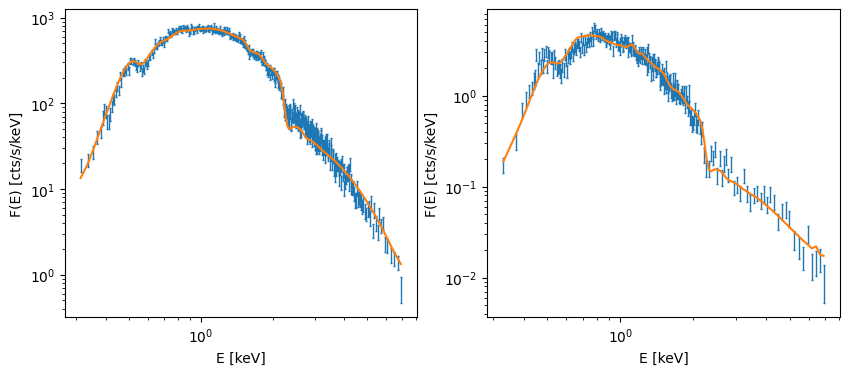

In [11]:
plt.figure(figsize=(10,4))
xs.Plot.xAxis = "keV"
xs.Plot.background = False
xs.Plot.setRebin(minSig=5, maxBins=20)
xs.Plot("data delchi")

for plot_grp in [1, 2]:
    plt.subplot(int(f"12{plot_grp}"))
    x = xs.Plot.x(plot_grp)
    y = xs.Plot.y(plot_grp)
    yerr = xs.Plot.yErr(plot_grp)
    ymo = xs.Plot.model(plot_grp)


    plt.errorbar(x, y, yerr=yerr, ls="", capsize=1, elinewidth=1)
    plt.loglog(x, ymo)

    # plt.xlim(0.3,7)
    plt.xlabel("E [keV]")
    plt.ylabel("F(E) [cts/s/keV]")

In [12]:
xs.Xset.chatter = 10
xs.Fit.show()
xs.Xset.chatter = 1


Fit statistic  : C-Statistic                 1146.83     using 683 bins, spectrum 1.
                 C-Statistic                  861.25     using 683 bins, spectrum 2.
Total fit statistic                          2008.09     with 1357 d.o.f.

Test statistic : Chi-Squared                 1976.90     using 1366 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 2 

 Null hypothesis probability of 6.04e-26 with 1357 degrees of freedom


In [37]:
xs.Plot("ldata chi")
energies = xs.Plot.x()
edeltas = xs.Plot.xErr()
rates = xs.Plot.y(1,1)
errors = xs.Plot.yErr(1,1)
foldedmodel = xs.Plot.model()
dataLabels = xs.Plot.labels(1)
chiLabels = xs.Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
chi = xs.Plot.y(1,2)
chi.append(chi[-1])

In [38]:
chi[-3:-1]

[-18.33489466064741, -20.98640460618865]

In [34]:
len(chi), len(energies)

(430, 429)

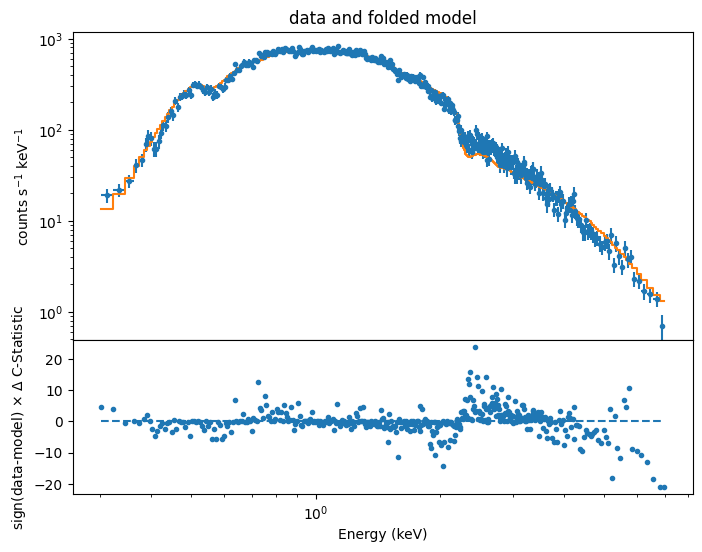

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(dataLabels[1])
ax1.set_title(dataLabels[2])
ax1.errorbar(energies, rates, xerr=edeltas, yerr=errors, fmt='.')
ax1.step(stepenergies, foldedmodel, where='post')

ax2.set_xscale('log')
ax2.set_xlabel(chiLabels[0])
ax2.set_ylabel(chiLabels[1])
ax2.errorbar(stepenergies, chi, fmt='.')
ax2.hlines(0.0, stepenergies[0], stepenergies[-1], linestyles='dashed')

<div class="alert alert-block alert-warning">
<b>References used to prepare this tutorial:</b> 
<br>1. https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/python/html/index.html
<br>2. https://github.com/xyzhang/eRASS-spectrum
<br>3. https://johannesbuchner.github.io/BXA/index.html
<br>4. https://github.com/HEASARC/PyXspec-Jupyter-notebooks/tree/main
</div>